Improving star-galaxy classification using mixture models
===============================

---

In this notebook we briefly show how extreme deconvolution (XD) can be a useful, unsupervised method for improving the way stars and galaxies are classified in astronomical imaging data.  Here is a breakdown of the key ideas:
- Astronomers measure the brightness of sources using 'star' models and 'galaxy' models, and report this in units of        magnitudes (more below).
- Using a threshold, the difference between these magnitudes determines the classification. 
- When the objects are faint, noise makes this an unreliable procedure.
- We want to create (hierarchically) a prior for these quantities, and do so by modeling the joint distribution of measurements using XD
- XD is a Gaussian Mixture Model which models the data as a GMM convolved with an objects measurement uncertainty.
- Using this prior we can estimate the posterior differences of magnitudes, producing a better classification

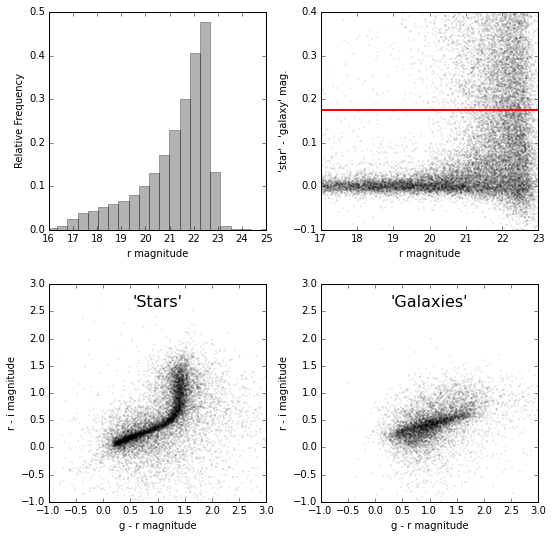

In [1]:
%matplotlib inline
import numpy as np
import pyfits as pf
import matplotlib.pyplot as pl

from xd import XDGMM, xd_model
from utils import load_xd_parms
from demo_utils import fake_data_plot, sdss_description_plot, sdss_results_plot

import warnings
warnings.filterwarnings('ignore')

# load some SDSS data and generate descriptive plot
f = pf.open('sdss_demo_train.fits')
X = f[0].data
Xcov = f[1].data
f.close()
sdss_description_plot(X)

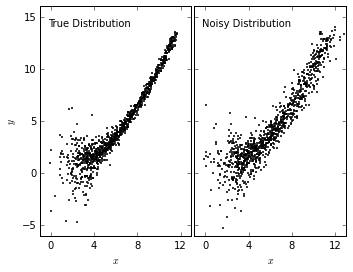

In [8]:
def generate_fake_data(N=1000, seed=1234):
    """
    Generate a set of fake data for demo purposes.
    """
    # generate the true data
    x_true = (1.4 + 2 * np.random.random(N)) ** 2
    y_true = 0.1 * x_true ** 2

    # add scatter to "true" distribution
    dx = 0.1 + 4. / x_true ** 2
    dy = 0.1 + 10. / x_true ** 2
    x_true += np.random.normal(0, dx, N)
    y_true += np.random.normal(0, dy, N)

    # add noise to get the "observed" distribution
    dx = 0.2 + 0.5 * np.random.random(N)
    dy = 0.2 + 0.5 * np.random.random(N)

    x = x_true + np.random.normal(0, dx)
    y = y_true + np.random.normal(0, dy)

    # stack the results for computation
    X = np.vstack([x, y]).T
    Xcov = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    Xcov[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T
    
    # show the data
    fake_data_plot(x_true, y_true, x, y)
    
    # save it to file
    hdulist = pf.HDUList([pf.PrimaryHDU(X), pf.ImageHDU(Xcov)])
    hdulist.writeto('fake_data.fits', clobber=True)
    
    return X, Xcov, x_true, y_true
    
X, Xcov, x_true, y_true = generate_fake_data()

In [10]:
def run_xd_on_fake(N=1000, n_components=8, datafile='fake_data.fits'):
    """
    Run `Extreme Deconvolution' on generated data.
    """
    batch_size = N
    model = XDGMM(datafile, n_components, batch_size, eta=0.,
                  n_iter=50, Nthreads=2, verbose=True)

run_xd_on_fake()


Initalization done in 0.38 sec
Initial Log Likelihood:  -3.92764787177
Initial Valid Log Likelihood:  -3.92764787177

|  iter   |  train L   |  valid L   | weight  | itr time | tot time |  Nbad   |
-------------------------------------------------------------------------------
|    0    |  -3.9045   |  -3.9045   |    1    |   0.44   |   0.44   |    0    |
|    1    |  -3.8938   |  -3.9045   |    1    |   0.33   |   0.78   |    0    |
|    2    |  -3.8875   |  -3.9045   |    1    |   0.33   |   1.1    |    0    |
|    3    |  -3.8833   |  -3.9045   |    1    |   0.33   |   1.4    |    0    |
|    4    |  -3.8804   |  -3.9045   |    1    |   0.33   |   1.8    |    0    |
|    5    |  -3.8782   |  -3.9045   |    1    |   0.33   |   2.1    |    0    |
|    6    |  -3.8765   |  -3.9045   |    1    |   0.33   |   2.4    |    0    |
|    7    |  -3.8752   |  -3.9045   |    1    |   0.33   |   2.8    |    0    |
|    8    |  -3.8742   |  -3.9045   |    1    |   0.33   |   3.1    |    0    |
|

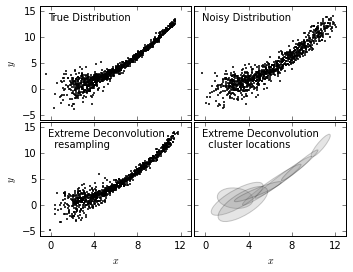

In [11]:
alphas, mus, Vs, logls, _ = load_xd_parms('xd_parms.hdf5')
model = xd_model(alphas.size, X.shape)
model.alpha = alphas
model.mu = mus
model.V = Vs

samples = model.sample(size=1000)

fake_data_plot(x_true, y_true, X[:, 0], X[:, 1], samples, mus, Vs)

In [5]:
f = pf.open('sdss_demo_valid.fits')
Xval = f[0].data
Xvalcov = f[1].data
f.close()

K = 32
Nstar = 16
fix = [-1, -2, -3, -4, -5]
fixed_means = np.zeros((K, Xval.shape[1])) + np.inf
fixed_means[:Nstar, fix] = np.zeros(len(fix))
aligned_covs = [(i, fix) for i in range(Nstar)]

In [7]:
n_iter = 30
Ncheck = 2
batch_size = 1000

model = XDGMM('sdss_demo_train.fits', K, batch_size=batch_size, n_iter=n_iter, Nthreads=2,
              verbose=True, Xvalid=Xval, Xvalidcov=Xvalcov,
              Ncheck=Ncheck, fixed_means=fixed_means, aligned_covs=aligned_covs,
              savefile='foo.hdf5', seed=1234)



Initalization done in 4.3 sec
Initial Log Likelihood:  -2.8825993598
Initial Valid Log Likelihood:  -3.20269284094

|  iter   |  train L   |  valid L   | weight  | itr time | tot time |  Nbad   |
-------------------------------------------------------------------------------
|    0    |  -2.4861   |  -3.0912   |    1    |   4.8    |   4.8    |    0    |
|    1    |  -2.7131   |  -3.0912   | 0.93101 |   1.9    |   6.7    |    0    |
|    2    |  -2.8212   |  -2.9079   | 0.8722  |   4.7    |    11    |    0    |
|    3    |  -2.7622   |  -2.9079   | 0.82138 |   2.4    |    14    |    0    |

Threw out 1 outliers.
|    4    |  -3.9362   |  -2.7827   | 0.77697 |   4.9    |    19    |    0    |
|    5    |  -2.8061   |  -2.7827   | 0.73779 |   1.9    |    21    |    0    |
|    6    |  -2.0046   |  -2.7296   | 0.70293 |   5.4    |    26    |    0    |
|    7    |  -2.1187   |  -2.7296   | 0.67168 |   1.6    |    28    |    0    |
|    8    |  -2.5469   |  -2.6845   | 0.6435  |   4.3    |  

In [3]:
alphas, mus, Vs, logls, _ = load_xd_parms('sdss_demo_parms.hdf5')
model = xd_model(alphas.size, Xval.shape)
model.alpha = alphas
model.mu = mus
model.V = Vs

pas, pms, pvs = model.posterior(Xval, Xvalcov)
samples = np.zeros_like(Xval)
for i in range(Xval.shape[0]):
    samples[i] = np.median(model.sample(pas[i], pms[i], pvs[i], 100), axis=0)

Posterior Calculation for datum 0
Posterior Calculation for datum 1000
Posterior Calculation for datum 2000
Posterior Calculation for datum 3000
Posterior Calculation for datum 4000


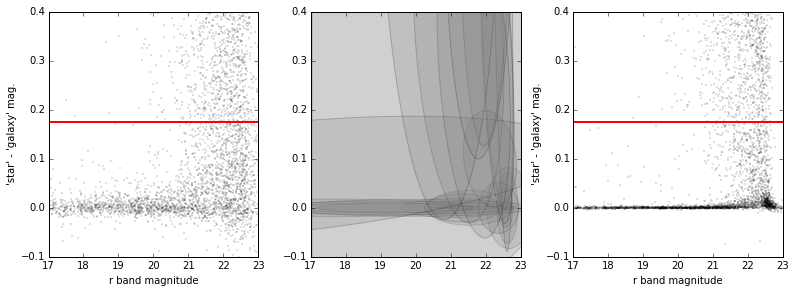

In [4]:
sdss_results_plot(Xval, samples, mus, Vs)